## NLP Class Assignment 5

In [51]:
import pandas as pd
import re
import os
import requests
import nltk as nltk
import nltk.corpus  
import matplotlib.pyplot as plt

from pandarallel import pandarallel
import re
import nltk
from nltk import word_tokenize, pos_tag, ne_chunk, TweetTokenizer
from collections import Counter
import spacy 


pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 500)

In [6]:
# Initialize pandarallel
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


#### Read news data

In [7]:
news_path = 'https://storage.googleapis.com/msca-bdp-data-open/news/nlp_a_5_news.json'
news_df = pd.read_json(news_path, orient='records', lines=True)

print(f'Sample contains {news_df.shape[0]:,.0f} news articles')
news_df.head(2)

Sample contains 10,012 news articles


,url,date,language,title,text
0,http://kokomoperspective.com/obituaries/jon-w-horton/article_b6ba8e1e-cb9c-11eb-9868-fb11b88b9778.html,2021-06-13,en,Jon W. Horton | Obituaries | kokomoperspective.com,Jon W. Horton | Obituaries | kokomoperspective.comYou have permission to edit this article. EditCloseSign Up Log In Dashboard LogoutMy Account Dashboard Profile Saved items LogoutCOVID-19Click here for the latest local news on COVID-19HomeAbout UsContact UsNewsLocalOpinionPoliticsNationalStateAgricultureLifestylesEngagements/Anniversaries/WeddingsAutosEntertainmentHealthHomesOutdoorsSportsNFLNCAAVitalsObituariesAutomotivee-EditionCouponsGalleries74°...
1,https://auto.economictimes.indiatimes.com/news/auto-components/birla-precision-to-ramp-up-capacity-to-tap-emerging-opportunities-in-india/81254902,2021-02-28,en,"Birla Precision to ramp up capacity to tap emerging opportunities in India, Auto News, ET Auto","Birla Precision to ramp up capacity to tap emerging opportunities in India, Auto News, ET Auto We have updated our terms and conditions and privacy policy Click ""Continue"" to accept and continue with ET AutoAccept the updated privacy & cookie policyDear user, ET Auto privacy and cookie policy has been updated to align with the new data regulations in European Union. Please review and accept these changes below to continue using the website.You can see our privacy policy & our cookie ..."


#### Read Tweets data

In [8]:
tweets_path = 'https://storage.googleapis.com/msca-bdp-data-open/tweets/nlp_a_5_tweets.json'
tweets_df = pd.read_json(tweets_path, orient='records', lines=True)
print(f'Sample contains {tweets_df.shape[0]:,.0f} tweets')
tweets_df.head(2)

Sample contains 10,105 tweets


,id,lang,date,name,retweeted,text
0,1534565117614084096,en,2022-06-08,Low Orbit Tourist 🌍📷,,"Body &amp; Assembly - Halewood - United Kingdom\n🌍53.3504,-2.8352296,402m\n\nHalewood Body &amp; Assembly is a Jaguar Land Rover factory in Halewood, England, and forms the major part of the Halewood complex which is shared with Ford who manufacture transmissions at the site. [Wikipedia] https://t.co/LPmCnZIaVt"
1,1534565743429394439,en,2022-06-08,CompleteCar.ie,RT,"Land Rover Ireland has announced that the new Range Rover Sport starts at €114,150, now on @completecar:\n\nhttps://t.co/TjGUkL3FYr https://t.co/QdVaEiJkjO"


## Twitter Data

### Clean the data

In [9]:
# Filter out retweets
tweets_df = tweets_df[tweets_df['retweeted'] != 'RT']
tweets_df = tweets_df[tweets_df['lang'] == 'en']

def clean(text):
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'@\w+', '', text)  # Remove mentions
    text = re.sub(r'#\w+', '', text)  # Remove hashtags
    text = re.sub(r'[^\w\s]', '', text)  # Remove special characters
    text = re.sub(r'(?:\n)','|', text) ## Remove new lines
    return text.strip()

tweets_df["text_cleaned"] = tweets_df["text"].apply(clean)

In [10]:
tweets_df.head(5)

,id,lang,date,name,retweeted,text,text_cleaned
0,1534565117614084096,en,2022-06-08,Low Orbit Tourist 🌍📷,,"Body &amp; Assembly - Halewood - United Kingdom\n🌍53.3504,-2.8352296,402m\n\nHalewood Body &amp; Assembly is a Jaguar Land Rover factory in Halewood, England, and forms the major part of the Halewood complex which is shared with Ford who manufacture transmissions at the site. [Wikipedia] https://t.co/LPmCnZIaVt",Body amp Assembly Halewood United Kingdom|53350428352296402m||Halewood Body amp Assembly is a Jaguar Land Rover factory in Halewood England and forms the major part of the Halewood complex which is shared with Ford who manufacture transmissions at the site Wikipedia
2,1529341557580652545,en,2022-05-25,Exmoor Trim,,New Land Rover Range Rover Hits Top Speed With Ease On Autobahn\n\nhttps://t.co/19QOgAIu3v,New Land Rover Range Rover Hits Top Speed With Ease On Autobahn||
3,1542790343535755264,en,2022-07-01,Land Rover UK,,"@BeckyWatts1 Hi, thank you for your post. I am sorry to learn of your retailer experience, however when order slots are available they will be presented to the retailer, and it is at their discretion which vehicles they submit. Please continue to liaise with them. Thanks, Dan - Land Rover UK",Hi thank you for your post I am sorry to learn of your retailer experience however when order slots are available they will be presented to the retailer and it is at their discretion which vehicles they submit Please continue to liaise with them Thanks Dan Land Rover UK
4,1516732103370493954,en,2022-04-20,Sussexes❤️👑🐼🌸,,@cofvefe917 @Mackingday No this was during the Land Rover driving challenge.,No this was during the Land Rover driving challenge
8,1545395541416321026,en,2022-07-08,Olu Femi,,Genuinely not a car person but that Land Rover defender is haunting me,Genuinely not a car person but that Land Rover defender is haunting me


### NLTK without Sentence Segmentation

In [11]:
def extract_entities(text):
    entities = []
    labels = []
    for chunk in ne_chunk(pos_tag(word_tokenize(text)), binary=False):
        if hasattr(chunk, 'label'):
            entities.append(' '.join(c[0] for c in chunk))  # Combine multi-token entities
            labels.append(chunk.label())
    entities_labels = list(set(zip(entities, labels)))  # Unique entities and labels
    return entities_labels

tweets_df['nltk_ner_whole'] = tweets_df['text_cleaned'].parallel_apply(extract_entities)

In [12]:
company_mentions = Counter()

for entities_labels in tweets_df['nltk_ner_whole']:
    for entity, label in entities_labels:
        if label == 'ORGANIZATION':  
            company_mentions[entity] += 1

# Get the most common 20 companies
top_20_companies = company_mentions.most_common(20)


In [13]:
# Convert the list to a DataFrame
top_20_nltk_ner_whole = pd.DataFrame(top_20_companies, columns=['Company', 'Mentions'])

# Display the DataFrame
print(top_20_nltk_ner_whole)

                        Company  Mentions
0                    Land Rover       580
1                          Land       370
2                          LAND       132
3                          eBay       107
4                         ROVER        73
5                   Jaguar Land        48
6                         Rover        45
7                           SUV        43
8                           BaT        34
9                         TEKNO        27
10                          BMW        26
11                           UK        23
12                         LIVE        15
13            Jaguar Land Rover        14
14                     Mercedes        13
15         Land Rover Discovery        13
16                         Ford        13
17                     RDynamic        13
18                          JLR        12
19  MHK100800 New Mass Air Flow        11


### NLTK with Sentence Segmentation

In [14]:
def extract_entities(text):
    entities = []
    labels = []
    for sent in nltk.sent_tokenize(text):
        for chunk in nltk.ne_chunk(nltk.pos_tag(nltk.word_tokenize(sent)), binary = False):
            if hasattr(chunk, 'label'):
                entities.append(' '.join(c[0] for c in chunk)) #Add space as between multi-token entities
                labels.append(chunk.label())
    entities_labels = list(set(zip(entities, labels)))  # Unique entities and labels
    return entities_labels

tweets_df['nltk_ner_sentence'] = tweets_df['text_cleaned'].parallel_apply(extract_entities)

In [15]:
company_mentions = Counter()

for entities_labels in tweets_df['nltk_ner_sentence']:
    for entity, label in entities_labels:
        if label == 'ORGANIZATION':  
            company_mentions[entity] += 1

# Get the most common 20 companies
top_20_companies = company_mentions.most_common(20)

In [16]:
# Convert the list to a DataFrame
top_20_nltk_ner_sentence = pd.DataFrame(top_20_companies, columns=['Company', 'Mentions'])

# Display the DataFrame
print(top_20_nltk_ner_sentence)

                        Company  Mentions
0                    Land Rover       580
1                          Land       370
2                          LAND       132
3                          eBay       107
4                         ROVER        73
5                   Jaguar Land        48
6                         Rover        45
7                           SUV        43
8                           BaT        34
9                         TEKNO        27
10                          BMW        26
11                           UK        23
12                         LIVE        15
13            Jaguar Land Rover        14
14                     Mercedes        13
15         Land Rover Discovery        13
16                         Ford        13
17                     RDynamic        13
18                          JLR        12
19  MHK100800 New Mass Air Flow        11


### SpaCy without Sentence Segmentation

In [17]:
nlp = spacy.load("en_core_web_lg")

In [19]:
def extract_entities_with_spacy(text):
    # Process the text with spaCy
    doc = nlp(text)
    
    entities = []
    labels = []
    
    # Extract entities and their labels
    for ent in doc.ents:
        entities.append(ent.text)
        labels.append(ent.label_)
    
    # Create a list of unique entity-label pairs
    entities_labels = list(set(zip(entities, labels)))
    
    return entities_labels

tweets_df['spacy_ner_whole'] = tweets_df['text_cleaned'].parallel_apply(extract_entities_with_spacy)

In [20]:
company_mentions = Counter()

for entities_labels in tweets_df['spacy_ner_whole']:
    for entity, label in entities_labels:
        if label == 'ORG':  
            company_mentions[entity] += 1

# Get the most common 20 companies
top_20_companies = company_mentions.most_common(20)

In [21]:
# Convert the list to a DataFrame
top_20_spacy_ner_whole = pd.DataFrame(top_20_companies, columns=['Company', 'Mentions'])

# Display the DataFrame
print(top_20_spacy_ner_whole)

                   Company  Mentions
0               Land Rover       413
1                     eBay       335
2        Jaguar Land Rover       273
3      Land Rover Defender       100
4                   Jaguar        72
5                    Rover        42
6            TEKNOOFFICIAL        41
7                     Ford        39
8                      BMW        38
9           the Land Rover        33
10                   Volvo        29
11             Range Rover        25
12                  Toyota        25
13                    Audi        24
14                 Porsche        24
15  Land Rover Range Rover        24
16                   Tesla        18
17             Tata Motors        17
18    Land Rover Defenders        17
19                Mercedes        16


### SpaCy with Sentence Segmentation

In [44]:
def extract_entities_with_spacy_sentence_segmentation(text):
    doc = nlp(text)
    
    entities = []
    labels = []
    
    # Iterate over sentences
    for sent in doc.sents:
        # Process each sentence for NER
        for ent in sent.ents:
            entities.append(ent.text)
            labels.append(ent.label_)

    # Create a list of unique entity-label pairs
    entities_labels = list(set(zip(entities, labels)))
    
    return entities_labels

tweets_df['spacy_ner_sentence'] = tweets_df['text_cleaned'].parallel_apply(extract_entities_with_spacy)

In [45]:
company_mentions = Counter()

for entities_labels in tweets_df['spacy_ner_sentence']:
    for entity, label in entities_labels:
        if label == 'ORG':  
            company_mentions[entity] += 1

# Get the most common 20 companies
top_20_companies = company_mentions.most_common(20)

In [46]:
# Convert the list to a DataFrame
top_20_spacy_ner_sentence_twiiter = pd.DataFrame(top_20_companies, columns=['Company', 'Mentions'])

# Display the DataFrame
print(top_20_spacy_ner_sentence_twiiter)

                   Company  Mentions
0               Land Rover       413
1                     eBay       335
2        Jaguar Land Rover       273
3      Land Rover Defender       100
4                   Jaguar        72
5                    Rover        42
6            TEKNOOFFICIAL        41
7                     Ford        39
8                      BMW        38
9           the Land Rover        33
10                   Volvo        29
11             Range Rover        25
12                  Toyota        25
13                    Audi        24
14                 Porsche        24
15  Land Rover Range Rover        24
16                   Tesla        18
17             Tata Motors        17
18    Land Rover Defenders        17
19                Mercedes        16


The four approaches demonstrate different models between NLTK and SpaCy. The sentence segmentation doesn't make a big change within the two models. However, NLTK model doesn't provide a clear perspective of companies, for example, it identifies some non-sense capital words as companies instead. On the other hand, the Spacy model does provide a robust identification, resulted in most of the companies are reasonable. Thus, Spacy model is much better.

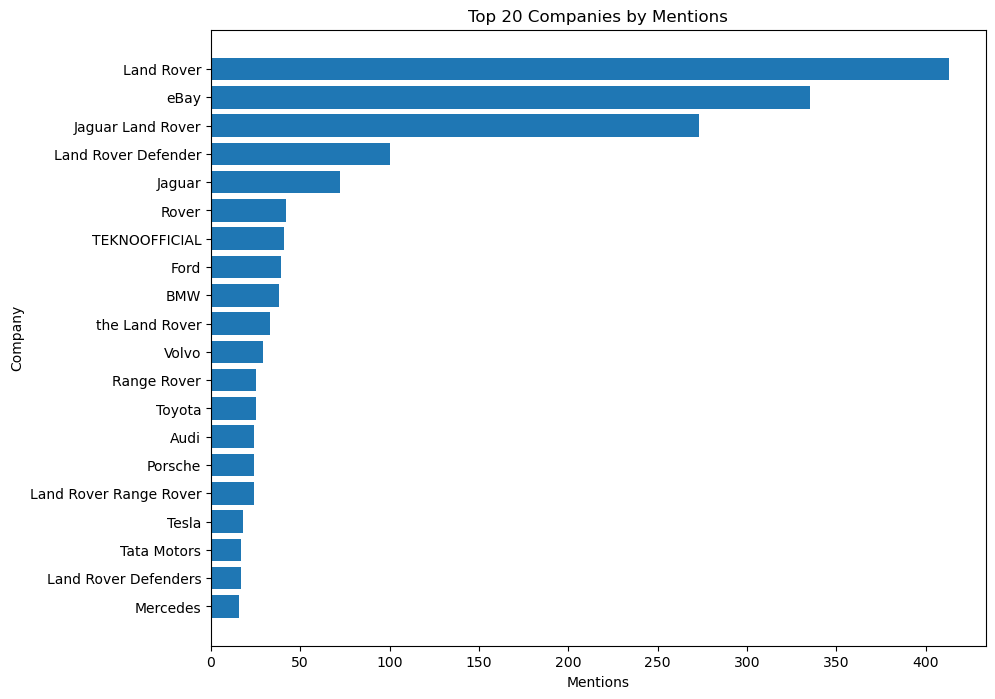

In [47]:
# Plotting
plt.figure(figsize=(10, 8))
plt.barh(top_20_spacy_ner_sentence_twiiter['Company'], top_20_spacy_ner_sentence_twiiter['Mentions'])
plt.xlabel('Mentions')
plt.ylabel('Company')
plt.title('Top 20 Companies by Mentions')
plt.gca().invert_yaxis()  # Invert y-axis to have the company with the highest mentions on top
plt.show()

## News Data

### Clean Data

In [48]:
news_df["text_cleaned"] = news_df["text"].apply(clean)
news_df["title_cleaned"]=news_df["title"].apply(clean)

In [24]:
news_df.head(10)

,url,date,language,title,text,text_cleaned
0,http://kokomoperspective.com/obituaries/jon-w-horton/article_b6ba8e1e-cb9c-11eb-9868-fb11b88b9778.html,2021-06-13,en,Jon W. Horton | Obituaries | kokomoperspective.com,Jon W. Horton | Obituaries | kokomoperspective.comYou have permission to edit this article. EditCloseSign Up Log In Dashboard LogoutMy Account Dashboard Profile Saved items LogoutCOVID-19Click here for the latest local news on COVID-19HomeAbout UsContact UsNewsLocalOpinionPoliticsNationalStateAgricultureLifestylesEngagements/Anniversaries/WeddingsAutosEntertainmentHealthHomesOutdoorsSportsNFLNCAAVitalsObituariesAutomotivee-EditionCouponsGalleries74°...,Jon W Horton Obituaries kokomoperspectivecomYou have permission to edit this article EditCloseSign Up Log In Dashboard LogoutMy Account Dashboard Profile Saved items LogoutCOVID19Click here for the latest local news on COVID19HomeAbout UsContact UsNewsLocalOpinionPoliticsNationalStateAgricultureLifestylesEngagementsAnniversariesWeddingsAutosEntertainmentHealthHomesOutdoorsSportsNFLNCAAVitalsObituariesAutomotiveeEditionCouponsGalleries74Fair ...
1,https://auto.economictimes.indiatimes.com/news/auto-components/birla-precision-to-ramp-up-capacity-to-tap-emerging-opportunities-in-india/81254902,2021-02-28,en,"Birla Precision to ramp up capacity to tap emerging opportunities in India, Auto News, ET Auto","Birla Precision to ramp up capacity to tap emerging opportunities in India, Auto News, ET Auto We have updated our terms and conditions and privacy policy Click ""Continue"" to accept and continue with ET AutoAccept the updated privacy & cookie policyDear user, ET Auto privacy and cookie policy has been updated to align with the new data regulations in European Union. Please review and accept these changes below to continue using the website.You can see our privacy policy & our cookie ...",Birla Precision to ramp up capacity to tap emerging opportunities in India Auto News ET Auto We have updated our terms and conditions and privacy policy Click Continue to accept and continue with ET AutoAccept the updated privacy cookie policyDear user ET Auto privacy and cookie policy has been updated to align with the new data regulations in European Union Please review and accept these changes below to continue using the websiteYou can see our privacy policy our cookie policy We use...
2,https://ca.sports.yahoo.com/news/global-hydrogen-fueling-station-markets-104800330.html?src=rss,2021-12-07,en,Global Hydrogen Fueling Station Markets to 2035: Current State and Future Prognosis of Passenger Hydrogen Fuel Cell Vehicles (FCVs),Global Hydrogen Fueling Station Markets to 2035: Current State and Future Prognosis of Passenger Hydrogen Fuel Cell Vehicles (FCVs) HOME MAIL NEWS SPORTS FINANCE CELEBRITY STYLE MOVIES WEATHER MOBILE Yahoo Sports Sign in Mail Sign in to view your mail Sports Home Sports Home Fantasy Fantasy Fantasy FootballFantasy Football Fantasy HockeyFantasy Hockey Fantasy BasketballFantasy Basketball Fantasy Auto RacingFantasy Auto Racing Fantasy Go...,Global Hydrogen Fueling Station Markets to 2035 Current State and Future Prognosis of Passenger Hydrogen Fuel Cell Vehicles FCVs HOME MAIL NEWS SPORTS FINANCE CELEBRITY STYLE MOVIES WEATHER MOBILE Yahoo Sports Sign in Mail Sign in to view your mail Sports Home Sports Home Fantasy Fantasy Fantasy FootballFantasy Football Fantasy HockeyFantasy Hockey Fantasy BasketballFantasy Basketball Fantasy Auto RacingFantasy Auto Racing Fantasy GolfF...
3,https://cardealermagazine.co.uk/publish/july-20-backlash-over-covid-passports-cummings-leaks-more-pm-texts-extreme-heat-warning-anniversary-mini-cooper-jcw-revealed/228570,2021-07-20,en,July 20: Backlash over Covid passports; Cummings leaks more PM texts; Extreme heat warning; Anniversary Mini Cooper JCW revealed – Car Dealer Magazine,July 20: Backlash over Covid passports; Cummings leaks more PM texts; Extreme heat warning; Anniversary Mini Cooper JCW revealed – Car Dealer Magazine Log inCar

### NLTK without Sentence Segmentation

In [16]:
def extract_entities(text):
    entities = []
    labels = []
    for chunk in ne_chunk(pos_tag(word_tokenize(text)), binary=False):
        if hasattr(chunk, 'label'):
            entities.append(' '.join(c[0] for c in chunk))  # Combine multi-token entities
            labels.append(chunk.label())
    entities_labels = list(set(zip(entities, labels)))  # Unique entities and labels
    return entities_labels

news_df['nltk_ner_whole'] = news_df['text_cleaned'].apply(extract_entities)

Process ForkPoolWorker-18:
Process ForkPoolWorker-19:
Process ForkPoolWorker-15:


KeyboardInterrupt: 

Process ForkPoolWorker-17:
Process ForkPoolWorker-16:
Process ForkPoolWorker-20:
Traceback (most recent call last):


In [12]:
company_mentions = Counter()

for entities_labels in tweets_df['nltk_ner_whole']:
    for entity, label in entities_labels:
        if label == 'ORGANIZATION':  
            company_mentions[entity] += 1

# Get the most common 20 companies
top_20_companies = company_mentions.most_common(20)


In [13]:
# Convert the list to a DataFrame
top_20_nltk_ner_whole = pd.DataFrame(top_20_companies, columns=['Company', 'Mentions'])

# Display the DataFrame
print(top_20_nltk_ner_whole)

                        Company  Mentions
0                       COVID19      3327
1                    RomeoAston      2224
2                 MakeAcuraAlfa      2030
3                         Daily      2023
4                            US      2019
5                            UK      1999
6                  insuranceCar      1984
7                    vehicleGet      1963
8     Autopath Technologies Inc      1962
9            DealerSite Account      1962
10                      TopMore      1961
11  Carpagesca Terms Conditions      1961
12                     MailMail      1948
13                    pageDaily      1948
14                   siteReader      1948
15                    PrintsOur      1948
16        MoneyMetroJobsiteMail      1940
17                        usHow      1919
18        Associated Newspapers      1919
19           complainLeadership      1905


### NLTK with Sentence Segmentation

In [34]:
def extract_entities(text):
    entities = []
    labels = []
    for sent in nltk.sent_tokenize(text):
        for chunk in nltk.ne_chunk(nltk.pos_tag(nltk.word_tokenize(sent)), binary = False):
            if hasattr(chunk, 'label'):
                entities.append(' '.join(c[0] for c in chunk)) #Add space as between multi-token entities
                labels.append(chunk.label())
    entities_labels = list(set(zip(entities, labels)))  # Unique entities and labels
    return entities_labels

news_df['nltk_ner_sentence'] = news_df['text_cleaned'].parallel_apply(extract_entities)

In [35]:
company_mentions = Counter()

for entities_labels in news_df['nltk_ner_sentence']:
    for entity, label in entities_labels:
        if label == 'ORGANIZATION':  
            company_mentions[entity] += 1

# Get the most common 20 companies
top_20_companies = company_mentions.most_common(20)

In [36]:
# Convert the list to a DataFrame
top_20_nltk_ner_sentence = pd.DataFrame(top_20_companies, columns=['Company', 'Mentions'])

# Display the DataFrame
print(top_20_nltk_ner_sentence)

                        Company  Mentions
0                       COVID19      3327
1                    RomeoAston      2224
2                 MakeAcuraAlfa      2030
3                         Daily      2023
4                            US      2019
5                            UK      1999
6                  insuranceCar      1984
7                    vehicleGet      1963
8     Autopath Technologies Inc      1962
9            DealerSite Account      1962
10  Carpagesca Terms Conditions      1961
11                      TopMore      1961
12                    PrintsOur      1948
13                     MailMail      1948
14                    pageDaily      1948
15                   siteReader      1948
16        MoneyMetroJobsiteMail      1940
17        Associated Newspapers      1919
18                        usHow      1919
19                    UsTermsDo      1905


### SpaCy without Sentence Segmentation

In [25]:
def extract_entities_with_spacy(text):
    # Process the text with spaCy
    doc = nlp(text)
    
    entities = []
    labels = []
    
    # Extract entities and their labels
    for ent in doc.ents:
        entities.append(ent.text)
        labels.append(ent.label_)
    
    # Create a list of unique entity-label pairs
    entities_labels = list(set(zip(entities, labels)))
    
    return entities_labels

news_df['spacy_ner_whole'] = news_df['text_cleaned'].parallel_apply(extract_entities_with_spacy)

In [49]:
company_mentions = Counter()

for entities_labels in news_df['spacy_ner_whole']:
    for entity, label in entities_labels:
        if label == 'ORG':  
            company_mentions[entity] += 1

# Get the most common 20 companies
top_20_companies = company_mentions.most_common(20)

In [50]:
# Convert the list to a DataFrame
top_20_spacy_ner_whole_news = pd.DataFrame(top_20_companies, columns=['Company', 'Mentions'])

# Display the DataFrame
print(top_20_spacy_ner_whole_news)

                                 Company  Mentions
0                              Instagram      1996
1                             siteReader      1948
2                               MailMail      1948
3                              PrintsOur      1948
4      Metro Media Groupdmg mediaContact      1905
5          Associated Newspapers LtdPart      1905
6                the Daily Mail The Mail      1905
7                                   Ford      1902
8                                 Amazon      1816
9                                 Toyota      1803
10                              Facebook      1757
11                               Netflix      1718
12                                   BMW      1603
13                               Hyundai      1429
14                                 Honda      1420
15                            MailOnline      1358
16                           FacebookYou      1345
17                       CrossoverPickup      1307
18  AccessibleMotorcycleCommerc

### SpaCy without Sentence Segmentation - News title

In [54]:
news_df['spacy_ner_whole_title'] = news_df['title_cleaned'].parallel_apply(extract_entities_with_spacy)
company_mentions = Counter()
for entities_labels in news_df['spacy_ner_whole_title']:
    for entity, label in entities_labels:
        if label == 'ORG':  
            company_mentions[entity] += 1
top_20_companies = company_mentions.most_common(20)

In [55]:
# Convert the list to a DataFrame
top_20_spacy_ner_whole_news_title = pd.DataFrame(top_20_companies, columns=['Company', 'Mentions'])

# Display the DataFrame
print(top_20_spacy_ner_whole_news_title)

                          Company  Mentions
0                      Daily Mail      1359
1                            Ford       314
2                          Toyota       204
3                         Hyundai       197
4                       Chevrolet       192
5                       Star News       182
6                           Honda       157
7                         Autocar       130
8             AutoSpies Auto News       124
9                          Nissan       123
10                            BMW       109
11                Automotive News       105
12                  Express  Star        98
13                Shropshire Star        88
14                       Roadshow        88
15            Car Dealer Magazine        85
16                            Kia        83
17                     Volkswagen        80
18                           Audi        77
19  Otago Daily Times Online News        76


Similar to twitter data, the Spacy does a better job in identifying companies. Especially, precisely identifying car's make as company instead of car's model. The news title is much more running efficiently comparing to news text. However, the title is too concise to indentify potential companies that mentioned in text. For example, "Instagram" is not mentioned in title ner. Thus, news text with Spacy ner is more comprehensive.

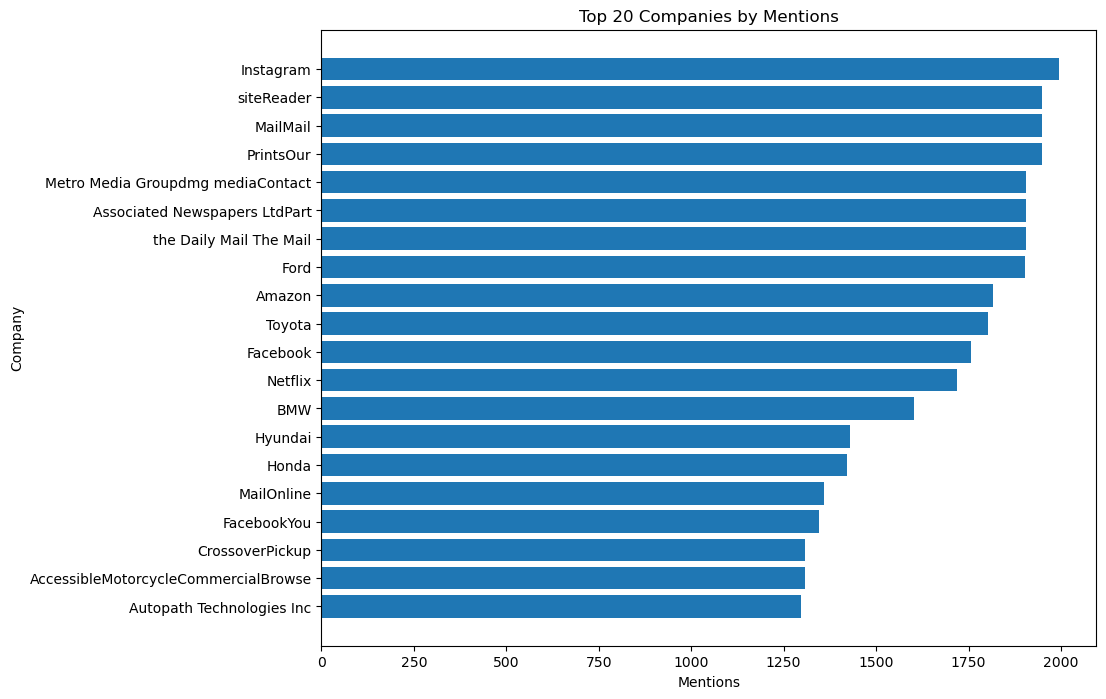

In [57]:
# Plotting
plt.figure(figsize=(10, 8))
plt.barh(top_20_spacy_ner_whole_news['Company'], top_20_spacy_ner_whole_news['Mentions'])
plt.xlabel('Mentions')
plt.ylabel('Company')
plt.title('Top 20 Companies by Mentions')
plt.gca().invert_yaxis()  # Invert y-axis to have the company with the highest mentions on top
plt.show()

### Primary Company between Twitter and News

In [59]:
overlapped_companies = pd.merge(top_20_spacy_ner_whole_news_title, top_20_spacy_ner_sentence_twiiter, on='Company', suffixes=('_news', '_twitter'))

overlapped_companies

,Company,Mentions_news,Mentions_twitter
0,Ford,314,39
1,Toyota,204,25
2,BMW,109,38
3,Audi,77,24


There are four primary companies that mentioned in both news and twitter

### Locations

In [64]:
# locations in twitter
locations_mentions = Counter()

for entities_labels in tweets_df['spacy_ner_sentence']:
    for entity, label in entities_labels:
        if label == 'LOC':  
            locations_mentions[entity] += 1

# Get the most common 20 companies
top_20_locations = locations_mentions.most_common(20)


# Convert the list to a DataFrame
top_20_spacy_ner_sentence_twiiter_location = pd.DataFrame(top_20_locations, columns=['Locations', 'Mentions'])

# Display the DataFrame
print(top_20_spacy_ner_sentence_twiiter_location)



                    Locations  Mentions
0                   Caribbean         6
1                      Africa         4
2                      Europe         3
3                    Midlands         2
4                        Mars         2
5                       Earth         2
6                   Carscoops         1
7                        Gulf         1
8    the North East||Envision         1
9                   Sand Hole         1
10   South China Morning Post         1
11                   Pecan AI         1
12              North America         1
13                  Cape Town         1
14                 Antarctica         1
15  West Knoxville Land Rover         1
16                 Bridgwater         1
17                         BC         1
18                 North West         1
19                 22|||| amp         1


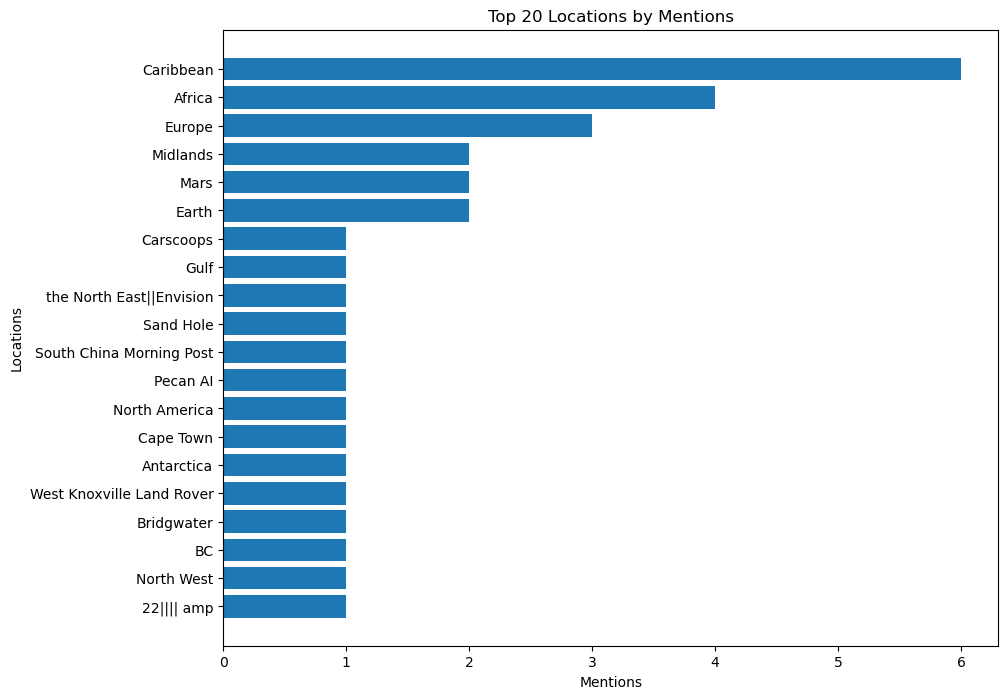

In [65]:
# Plotting
plt.figure(figsize=(10, 8))
plt.barh(top_20_spacy_ner_sentence_twiiter_location['Locations'], top_20_spacy_ner_sentence_twiiter_location['Mentions'])
plt.xlabel('Mentions')
plt.ylabel('Locations')
plt.title('Top 20 Locations by Mentions')
plt.gca().invert_yaxis()  # Invert y-axis to have the company with the highest mentions on top
plt.show()

In [67]:
# Location in News
# locations in twitter
locations_mentions = Counter()

for entities_labels in news_df['spacy_ner_whole']:
    for entity, label in entities_labels:
        if label == 'LOC':  
            locations_mentions[entity] += 1

# Get the most common 20 companies
top_20_locations = locations_mentions.most_common(20)


# Convert the list to a DataFrame
top_20_spacy_ner_sentence_news_location = pd.DataFrame(top_20_locations, columns=['Locations', 'Mentions'])

# Display the DataFrame
print(top_20_spacy_ner_sentence_news_location)

                       Locations  Mentions
0                         Europe      1093
1                          Earth       657
2                       Americas       432
3                    Love Island       406
4                      Caribbean       374
5                   Central Park       322
6                         Africa       316
7                 West Hollywood       288
8                            NYC       282
9                       Catch LA       262
10                       Jupiter       244
11                          Asia       232
12                 Mediterranean       222
13            the Blue Mountains       218
14                          Cabo       217
15               StarBay Harbour       211
16                          Gulf       189
17                    Kanye West       167
18  Winter Wonderlands VIP night       167
19             the American West       162


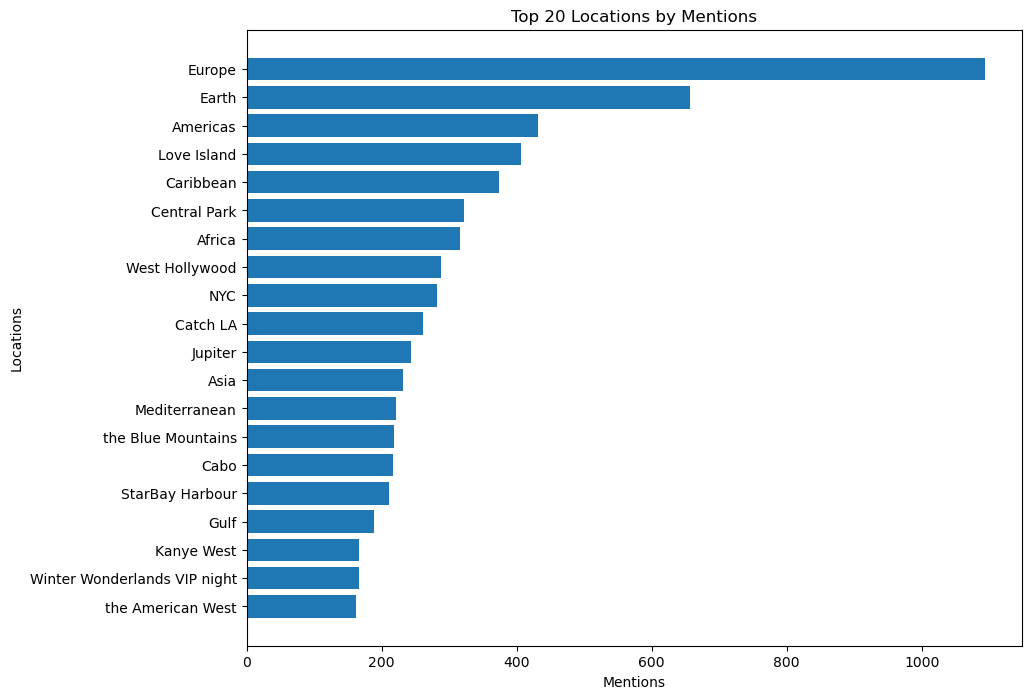

In [68]:
# Plotting
plt.figure(figsize=(10, 8))
plt.barh(top_20_spacy_ner_sentence_news_location['Locations'], top_20_spacy_ner_sentence_news_location['Mentions'])
plt.xlabel('Mentions')
plt.ylabel('Locations')
plt.title('Top 20 Locations by Mentions')
plt.gca().invert_yaxis()  # Invert y-axis to have the company with the highest mentions on top
plt.show()

### Primary Locations between News and Twitters

In [70]:
overlapped_locations = pd.merge(top_20_spacy_ner_sentence_news_location, top_20_spacy_ner_sentence_twiiter_location, on='Locations', suffixes=('_news', '_twitter'))

overlapped_locations

,Locations,Mentions_news,Mentions_twitter
0,Europe,1093,3
1,Earth,657,2
2,Caribbean,374,6
3,Africa,316,4
4,Gulf,189,1
